## Importing Libraries

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import seaborn as sns
import pandas as pd
import scipy
from IPython.display import display
from IPython.display import Image
from sklearn.datasets import make_regression
from sklearn import tree
import graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from mlxtend.plotting import plot_decision_regions

## Adaboost Forests are usually just stumps 
1. Stumps are trees with a node and two leaves
2. These are weak learners
3. Unlike RF, with Adaboost some stumps are weighted in terms of voting
4. Unlike RF where each tree is independent, with Adaboost order is important
5. By paying more attention to the training instances that the predecessor underfitted a new predictor can correct its predecessor. Resultantly, new predictors focuse more and more on the hard cases. 
6. Building an AdaBoost classifier:

     - a first base classifier is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. 
     - A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.
     


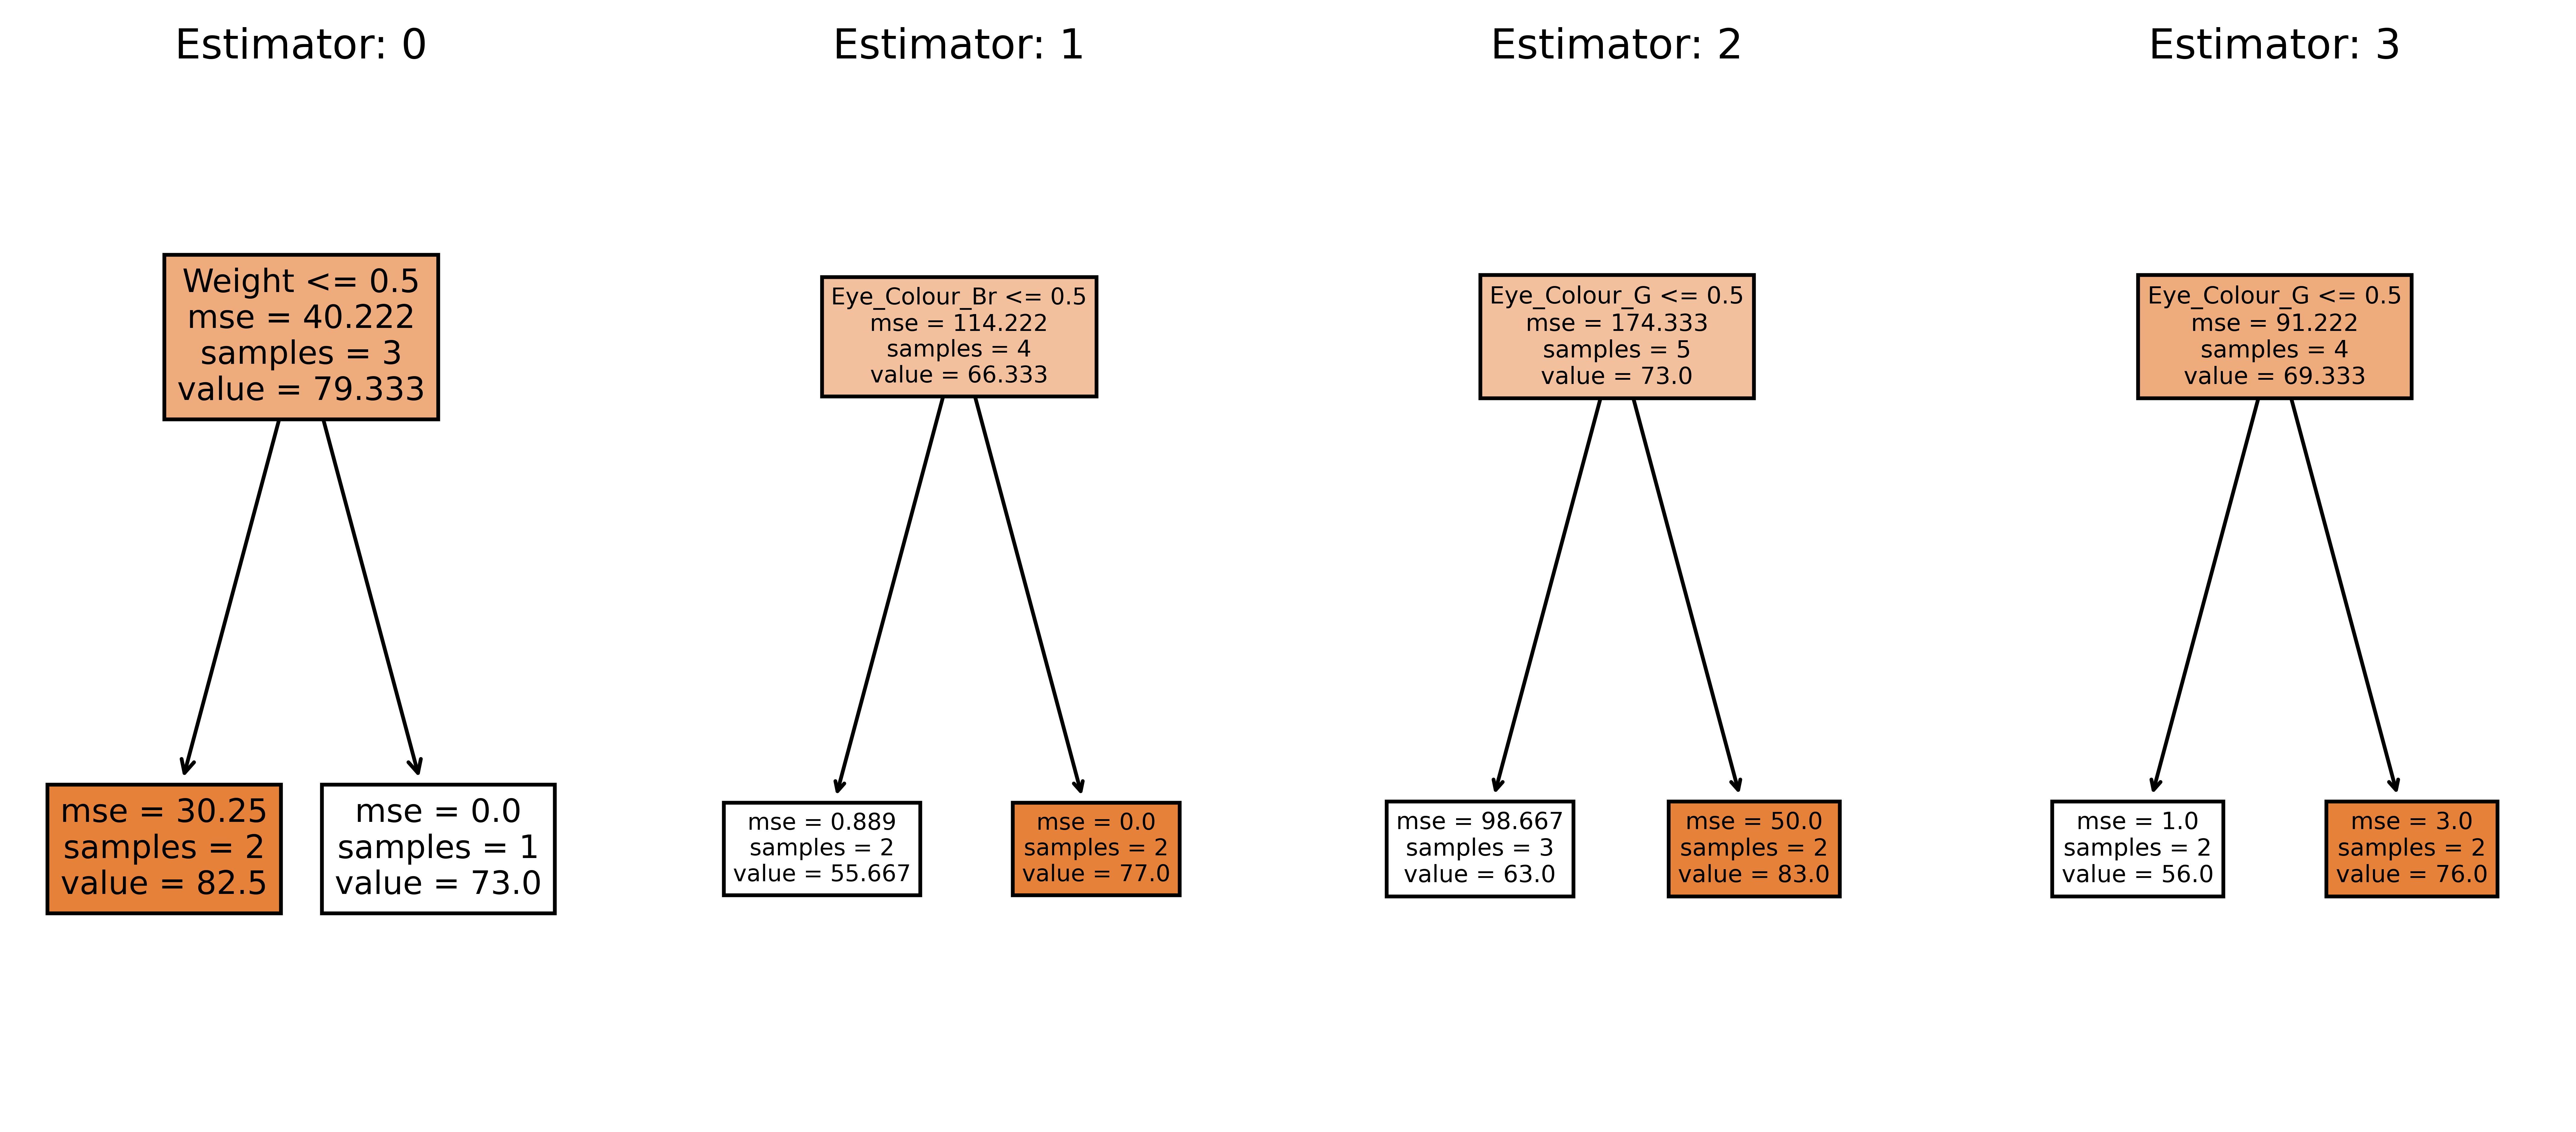

In [179]:
# creating a dataframe
gboost_df = pd.DataFrame({'Height':[1.6,1.6,1.5,1.8,1.5,1.6],'Eye_Colour':['B','G','B','Br','G','B'], 
                          'Gender': ['M','F','F','M','M','F'], 'Weight':[88,77,55,73,77,57]})


gboost_dummies = pd.get_dummies(gboost_df,drop_first=True)

X = gboost_dummies.drop('Weight',axis=1).values
y = gboost_dummies['Weight'].values

fn=gboost_dummies.columns[:-1]


clf = RandomForestRegressor(max_depth = 1)
clf = clf.fit(X,y)

fig, axes = plt.subplots(nrows = 1,ncols = 4,figsize = [12,5], dpi=900)
for index in range(0, 4):
    tree.plot_tree(clf.estimators_[index],
                   filled = True,
                   feature_names = fn,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

## Gradient Boosting

Instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

1. Gradient Boost starts by making a single leaf which is an initial guess for our dependant variable (continuos normally average)


2. Usually larger than a stump but tree size is still restricted (max leaves between 8 and 32)



3. Our second tree is built based on the residual errors of of first leaf

In [180]:
# creating a dataframe
gboost_df = pd.DataFrame({'Height':[1.6,1.6,1.5,1.8,1.5,1.6],'Eye_Colour':['B','G','B','Br','G','B'], 
                          'Gender': ['M','F','F','M','M','F'], 'Weight':[88,77,55,73,77,57]})

# Our Dependant variable is continuous so we calculate average weight
avg_weight = np.mean(gboost_df['Weight'])

# residual (Observed - Predicted)
gboost_df['Residual'] = gboost_df['Weight'] - avg_weight

gboost_df

,Height,Eye_Colour,Gender,Weight,Residual
0,1.6,B,M,88,16.833333
1,1.6,G,F,77,5.833333
2,1.5,B,F,55,-16.166667
3,1.8,Br,M,73,1.833333
4,1.5,G,M,77,5.833333
5,1.6,B,F,57,-14.166667


## Second Tree

We will build our second tree using our Height, Eye_Colour, and Gender to predict the **residuals**. Since our data is small we will restirct our trees to 4 leaves

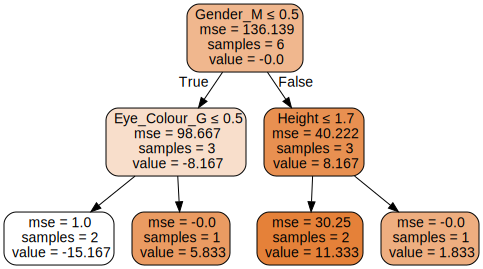

In [181]:
dummy_boost = pd.get_dummies(gboost_df,drop_first=True)

X = dummy_boost.drop(['Weight','Residual'],axis=1).values
y = dummy_boost['Residual'].values

fn=dummy_boost.columns[[0,3,4,5]]


rf_clf = DecisionTreeRegressor(max_leaf_nodes = 4)
rf_clf = rf_clf.fit(X,y)

dot_data = tree.export_graphviz(rf_clf, out_file=None, 
                     feature_names= fn,  
                     filled=True, rounded=True,  
                    special_characters=True)  
graphviz.Source(dot_data)  

In [182]:
# Bottom left-left leaf we can see the average residual is -15.167 from the mean of -16.16 & -14.16
dummy_boost[(dummy_boost['Gender_M']==0)& (dummy_boost['Eye_Colour_G']<0.5) ]

,Height,Weight,Residual,Eye_Colour_Br,Eye_Colour_G,Gender_M
2,1.5,55,-16.166667,0,0,0
5,1.6,57,-14.166667,0,0,0


In [183]:
# Bottom left-middle leaf
dummy_boost[(dummy_boost['Gender_M']==0)& (dummy_boost['Eye_Colour_G']>0.5) ]

,Height,Weight,Residual,Eye_Colour_Br,Eye_Colour_G,Gender_M
1,1.6,77,5.833333,0,1,0


In [184]:
# Bottom right-middle leaf we can see the average residual is 11.33 from the mean of 16.83 & 5.83
dummy_boost[(dummy_boost['Gender_M']==1)& (dummy_boost['Eye_Colour_Br']<0.5) ]

,Height,Weight,Residual,Eye_Colour_Br,Eye_Colour_G,Gender_M
0,1.6,88,16.833333,0,0,1
4,1.5,77,5.833333,0,1,1


In [185]:
# Bottom right-right leaf
dummy_boost[(dummy_boost['Gender_M']==1)& (dummy_boost['Eye_Colour_Br']>0.5) ]

,Height,Weight,Residual,Eye_Colour_Br,Eye_Colour_G,Gender_M
3,1.8,73,1.833333,1,0,1


## Combining Leaf and second Tree to make predictions
Person index 3 above ended on the bottom right leaf with a value of 1.833. If we add that to our average weight (leaf one) we have 71.16 + 1.833 = 73

1. This is suspicious as our data is overfitting our training data and will not generalize well on new data


2. Gradient Boost uses a learning rate to scale the contribution from the new tree

If our learning rate is 0.1 then: $$71.16 + 0.1(1.833) = 71.34$$

This is better than our original leaf and shows a step in the correct direction. Taking smaller steps in the right direction results in better predictions and lower variance


## Building Another Tree

We calculate our residuals again but scale our predicted value $(average + 0.1*(leafnode))$

Where:
    
    
* learning rate: 0.1  

* leaf_node: value on our decision tree in which leaf it ended up in


In [186]:
dummy_boost.iloc[[2,5],2] = dummy_boost[(dummy_boost['Gender_M']==0)& (dummy_boost['Eye_Colour_G']<0.5)]['Weight'] - (avg_weight + 0.1* -15.167)

dummy_boost.iloc[[0,4],2] = dummy_boost[(dummy_boost['Gender_M']==1)& (dummy_boost['Eye_Colour_Br']<0.5)]['Weight'] - (avg_weight + 0.1* 11.333)

dummy_boost.iloc[[3],2] = dummy_boost[(dummy_boost['Gender_M']==1)& (dummy_boost['Eye_Colour_Br']>0.5)]['Weight'] - (avg_weight + 0.1* 1.833)

dummy_boost.iloc[[1],2] = dummy_boost[(dummy_boost['Gender_M']==0)& (dummy_boost['Eye_Colour_G']>0.5)]['Weight'] - (avg_weight + 0.1* 5.833)


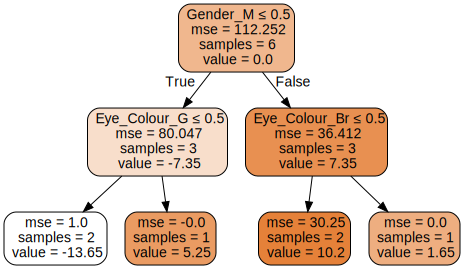

In [187]:
X = dummy_boost.drop(['Weight','Residual'],axis=1).values
y = dummy_boost['Residual'].values

fn=dummy_boost.columns[[0,3,4,5]]


clf = DecisionTreeRegressor(max_leaf_nodes = 4)
clf = clf.fit(X,y)

dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names= fn,  
                     filled=True, rounded=True,  
                    special_characters=True)  
graphviz.Source(dot_data)  

In [188]:
dummy_boost[(dummy_boost['Gender_M']==1)& (dummy_boost['Height']>1.7) ]

,Height,Weight,Residual,Eye_Colour_Br,Eye_Colour_G,Gender_M
3,1.8,73,1.650033,1,0,1


## Combining Leaf, second and third Tree to make predictions
For our same patient:

1. If our learning rate is 0.1 then: $$71.16 + 0.1(1.833) + 0.1(1.65) = 71.5083$$

This is better than our original leaf and second Tree and shows a step in the correct direction. Taking smaller steps in the right direction results in better predictions and lower variance. We repeat these steps until we have a perfect match or our residuals are so small that we stop

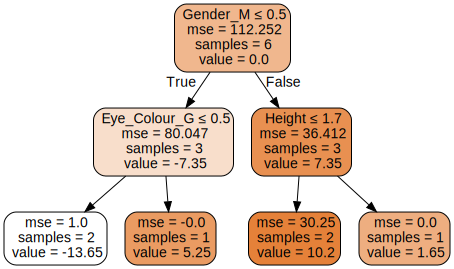

In [189]:
fn=dummy_boost.columns[[0,3,4,5]]

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1 = tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2 = tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3 = tree_reg3.fit(X, y3)


graphviz.Source(tree.export_graphviz(tree_reg1, out_file=None, 
                     feature_names=fn,  
                     filled=True, rounded=True,  
                    special_characters=True))


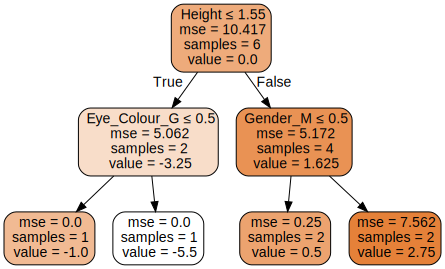

In [190]:
graphviz.Source(tree.export_graphviz(tree_reg2, out_file=None, 
                     feature_names=fn,  
                     filled=True, rounded=True,  
                    special_characters=True))

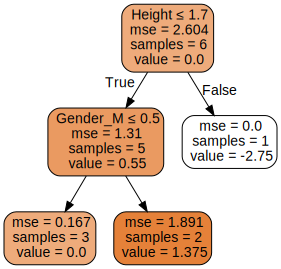

In [191]:
graphviz.Source(tree.export_graphviz(tree_reg3, out_file=None, 
                     feature_names=fn,  
                     filled=True, rounded=True,  
                    special_characters=True))

# Gradient Boost algorithm


To solve any supervised Machine Learning problem, given the dataset:
$$\{(x_i,y_i\}_{i=1}^{n}$$

and a differential **loss function**:
$$L(y,f)$$


We are trying to find the values of our parameters than minimize our differentiable loss function:


$$\hat f(x) = argmin\sum_{i=1}^{n}[L(y,f(x))]$$


Therefore, to train a Linear Model, we will define a function that measures, for each value of the $\theta$, how close $h(x^{i})$ are to the corresponding $y^i$ using the least squares cost function that gives rise to the ordinary least squares regression model

$$ J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(y^{(i)}-h_\theta(x^{(i)}) )^2$$

Where:

- $h_\theta(x^{(i)})$: is our predicted


- $y^{(i)}$ is our observed





Notably, the partial derivative with respect to our predicted variable:

$$-(h_\theta(x^{(i)}) - y^{(i)})$$




In [192]:
# creating a dataframe
gboost = pd.DataFrame({'Height':[1.6,1.6,1.5,1.8,1.5,1.6],'Eye_Colour':['B','G','B','Br','G','B'], 
                          'Gender': ['M','F','F','M','M','F'], 'Weight':[88,77,55,73,77,57]})
df_boost = pd.get_dummies(gboost,drop_first=True)
df_boost = df_boost.head(3)
df_boost

,Height,Weight,Eye_Colour_Br,Eye_Colour_G,Gender_M
0,1.6,88,0,0,1
1,1.6,77,0,1,0
2,1.5,55,0,0,0


### The partial derivative with respect to our predicted variable

$$patient_0 = -(88-Predicted_0)$$
$$patient_1 = -(77-Predicted_1)$$
$$patient_2 = -(55-Predicted_2)$$

$$Predictedx3 = 88+77+55$$


$$Predicted = \frac{88+77+55}{3} = 73.3$$


Given our loss function $L(y,f)$ the value for theta/gamma that min our cost function for the first iteration is the average of the observed weights

Therefore, we have created the intial predicted value for $F_0(x)$ and this prediction is just a leaf


### Step 2: 
For m = 1 to M (number of trees we want to make):

#### A. Compute: 
$$ r_{im}-[\frac{\partial L(y_i,f(x_i))}{\partial f(x_i)}]_{F(x)=F_{m-1}(x)}$$ 

Where the middle function is just the partial derivative with respect to our predicted variable which we calculated:

$$-[-(h_\theta(x^{(i)}) - y^{(i)})]$$

So in otherwords our derivative with respect to our predicted variable is simply:

$$(Observed-Predicted)$$


If we plug in (Observed - $F_{m-1}(x))$ and our m is our first tree m =1:
$$F_{m-1}(x))$ = $F_0(x))$$

$$F_0(x)) = 73.3$$

Where:

* $r_{im}$ is the residual (r) 
* for the $i^{th}$ (i) sample 
* in the $m^{th}$ tree



$$r_{1,1} = (88 - 73.3) = 14.7$$


$$r_{2,1} = (77 - 73.3) = 3.7$$


$$r_{3,1} = (55 - 73.3) = -18.29$$


#### B. Fit a regression tree to the $r_{im}$ values
- Create terminal regions $R_{jm}$ for $j = 1...j_m$
    - So we create a regression tree to predict the residuals where our leaves in our new trees are our $R_{jm}$ where j is the index of that leaf and m is the tree
    
    
#### C. Output values for each leaf 
1. For $j = 1..j_m$ compute:
$$\gamma_{jm} = argmin\sum_{x_i\in R_{ij}}{} L(y_i, F_{m-1}(x_i)+\gamma)$$

We are trying to find a $\gamma$ that minimizes the formula above but now we have our predicted value from our first leaf

- ${x_i\in R_{ij}}$ selects only the samples within a specific leaf

In [193]:
avg_weight = np.mean(df_boost['Weight'])
df_boost['residual'] = df_boost['Weight'] - avg_weight
df_boost

,Height,Weight,Eye_Colour_Br,Eye_Colour_G,Gender_M,residual
0,1.6,88,0,0,1,14.666667
1,1.6,77,0,1,0,3.666667
2,1.5,55,0,0,0,-18.333333


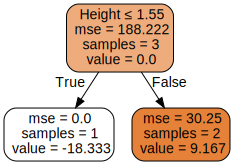

In [194]:
X = df_boost.drop(['Weight','residual'],axis=1).values
y = df_boost['residual'].values

fn=df_boost.columns[[0,2,3,4]]


boosted_clf = DecisionTreeRegressor(max_depth=1)
boosted_clf = boosted_clf.fit(X,y)

dot_data = tree.export_graphviz(boosted_clf, out_file=None, 
                     feature_names= fn,  
                     filled=True, rounded=True,  
                    special_characters=True)  
graphviz.Source(dot_data) 

In [195]:
df_boost[(df_boost['Height']<1.55)]

,Height,Weight,Eye_Colour_Br,Eye_Colour_G,Gender_M,residual
2,1.5,55,0,0,0,-18.333333


In [196]:
df_boost[(df_boost['Height']>1.55)]

,Height,Weight,Eye_Colour_Br,Eye_Colour_G,Gender_M,residual
0,1.6,88,0,0,1,14.666667
1,1.6,77,0,1,0,3.666667


## Finding $\gamma$

Formula: 
$$\gamma_{jm} = argmin\sum_{x_i\in R_{ij}}{} L(y_i, F_{m-1}(x_i)+\gamma)$$


$$\gamma_{1,1} = argmin\frac{1}{2}((55 -73.3)+\gamma)^{2}$$

$$\gamma_{1,1} = argmin\frac{1}{2}(-18.333 - \gamma)^{2}$$

$$\gamma_{1,1} = argmin\frac{1}{2}(-18.333 - \gamma)^{2}$$


Now taking the derivative:

$$\gamma_{1,1} = -18.333$$

Now for our second leaf:

$$\gamma_{2,1} = argmin[\frac{1}{2}((88 -73.3)+\gamma)^{2} + \frac{1}{2}((77 -73.3)+\gamma)^{2}]$$

$$\gamma_{2,1} = argmin\frac{1}{2}(14.7 - \gamma)^{2} + \frac{1}{2}(3.7 - \gamma)^{2}$$


Now taking the derivative:

$$\gamma_{2,1} = \frac{14.7+3.7}{2} = 9.167$$


Because of our loss function the residuals of our leaf are the average values of that leaf


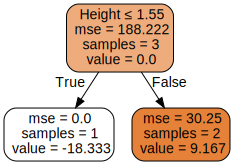

In [197]:
graphviz.Source(dot_data) 

## Updating rule

$$F_m(x) = F_{m-1}(x) + \nu \sum_{j=1}^{J_m} \gamma_{jm}I(x \in R_{jm})$$

where:
$\nu$: our learning rate

$\sum_{j=1}^{J_m} \gamma_{jm}I(x \in R_{jm})$: Sum up all the output values $\gamma_{jm}$ for all the leaves that our x can be found in or is a member of 

$$F_1(x) = F_0(x) + \nu (value[-18.333 \text{ or } 9.167)$$

for our patient below who ended up in the left leaf:

$$F_1(x) = 73.3 + 0.1 (-18.333)$$

Our prediction is thus 71.4667 which is moving closer to 55 than our inital prediction of 73.3

In [198]:
df_boost = df_boost.drop('residual',axis=1)
df_boost[(df_boost['Height']<1.55)]

,Height,Weight,Eye_Colour_Br,Eye_Colour_G,Gender_M
2,1.5,55,0,0,0


## Sklearn Implementation

In [199]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=1, n_estimators=3, learning_rate=0.3)
gbrt = gbrt.fit(X, y)